# Classification Toko Baju using GRU
## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import sigmoid


In [ ]:
# Load dataset dari GitHub
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
df = pd.read_csv(url)
df.head()


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
# Ambil teks dan label
df = df[['Review Text', 'Recommended IND']].dropna()
texts = df['Review Text'].values
labels = df['Recommended IND'].values

In [ ]:
from collections import Counter
import re

def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.split()

# Buat vocab
all_tokens = [token for sentence in texts for token in tokenize(sentence)]
vocab = {word: i+1 for i, (word, _) in enumerate(Counter(all_tokens).most_common())}
vocab['<PAD>'] = 0

# Ubah teks ke angka
def encode(text):
    return [vocab.get(word, 0) for word in tokenize(text)]

encoded_texts = [torch.tensor(encode(t)) for t in texts]
padded_texts = pad_sequence(encoded_texts, batch_first=True)
labels = torch.tensor(labels).float()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_texts, labels, test_size=0.2, random_state=42)

class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
import torch
import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_layers=1):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        x = self.dropout(h_n[-1])
        x = self.fc(x)
        return torch.sigmoid(x)


vocab_size = len(vocab)
model = GRUClassifier(vocab_size=vocab_size, embedding_dim=356, hidden_dim=128)


In [ ]:
model = GRUClassifier(vocab_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_history = []
train_acc_history = []

for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    acc = correct / total
    train_loss_history.append(total_loss / len(train_loader))
    train_acc_history.append(acc)

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc*100:.2f}%")


Epoch 1, Loss: 266.6073, Accuracy: 81.71%
Epoch 2, Loss: 176.3510, Accuracy: 86.38%
Epoch 3, Loss: 121.3930, Accuracy: 91.22%
Epoch 4, Loss: 91.0744, Accuracy: 93.74%
Epoch 5, Loss: 64.3329, Accuracy: 96.07%
Epoch 6, Loss: 44.8902, Accuracy: 97.38%
Epoch 7, Loss: 30.8064, Accuracy: 98.42%
Epoch 8, Loss: 23.4229, Accuracy: 98.72%
Epoch 9, Loss: 15.8696, Accuracy: 99.22%
Epoch 10, Loss: 15.0055, Accuracy: 99.18%


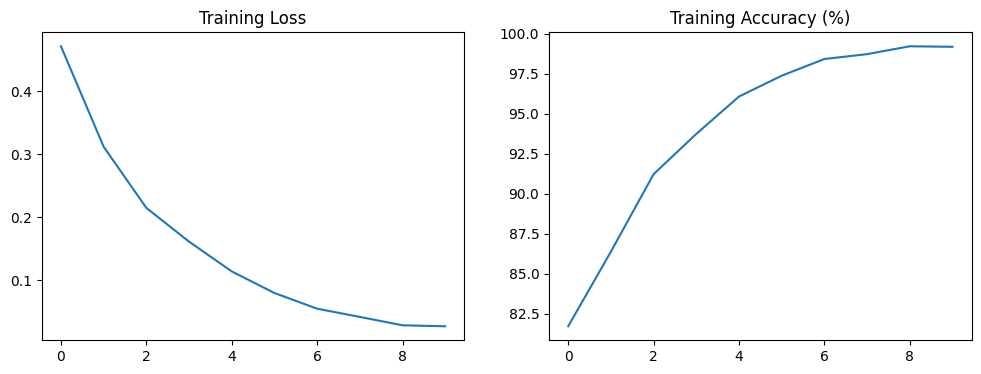

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_loss_history)
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(np.array(train_acc_history)*100)
plt.title('Training Accuracy (%)')
plt.show()


In [ ]:
def evaluate(model, loader, y_true):
    model.eval()
    y_preds, y_probs = [], []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs > 0.5).int().cpu().numpy()
            y_probs.extend(probs)
            y_preds.extend(preds)

    acc = accuracy_score(y_true, y_preds)
    prec = precision_score(y_true, y_preds)
    rec = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    f1_sq = f1**2
    auc = roc_auc_score(y_true, y_probs)
    loss = log_loss(y_true, y_probs)

    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F1 Squared: {f1_sq:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Loss: {loss:.4f}\n")

# Evaluasi
print("🔍 Final Results:")
print("Training Set Metrics:")
evaluate(model, train_loader, y_train.numpy())

print("Test Set Metrics:")
evaluate(model, test_loader, y_test.numpy())

🔍 Final Results:
Training Set Metrics:
Accuracy: 70.58%
Precision: 0.8208
Recall: 0.8195
F1 Score: 0.8201
F1 Squared: 0.6726
AUC: 0.5091
Loss: 1.8913

Test Set Metrics:
Accuracy: 87.92%
Precision: 0.9236
Recall: 0.9298
F1 Score: 0.9267
F1 Squared: 0.8587
AUC: 0.9182
Loss: 0.4954



📊 Confusion Matrix & ROC Curve (Side-by-Side):


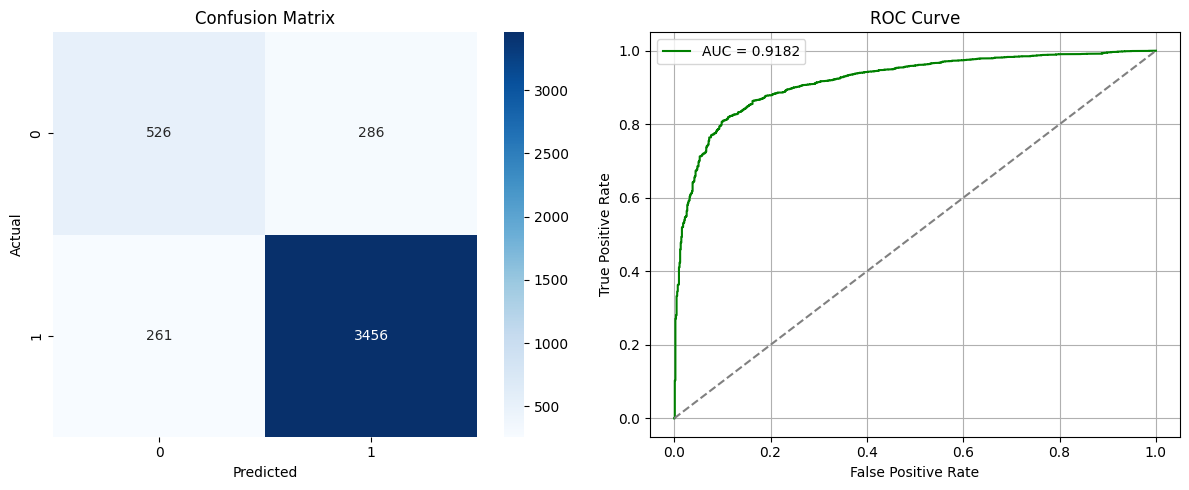

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

def plot_roc_and_confusion_matrix_side_by_side(model, loader, y_true):
    model.eval()
    y_probs = []
    y_preds = []

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs > 0.5).int().cpu().numpy()
            y_probs.extend(probs)
            y_preds.extend(preds)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_preds)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # ROC Curve
    axes[1].plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='green')
    axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[1].set_title('ROC Curve')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

# Tampilkan hasil
print("📊 Confusion Matrix & ROC Curve (Side-by-Side):")
plot_roc_and_confusion_matrix_side_by_side(model, test_loader, y_test.numpy())


# Penjelasan Rumus
---
##🔹 Rumus GRU (Gated Recurrent Unit)

GRU adalah jenis RNN (Recurrent Neural Network) yang menyederhanakan arsitektur LSTM. GRU menggunakan dua gerbang utama: **update gate** dan **reset gate**.

#### 1. Update Gate

Update gate menentukan seberapa banyak informasi dari waktu sebelumnya yang harus dibawa ke waktu saat ini.

$$
z_t = \sigma(W_z \cdot x_t + U_z \cdot h_{t-1})
$$

#### 2. Reset Gate

Reset gate menentukan seberapa banyak informasi dari waktu sebelumnya yang harus dilupakan.

$$
r_t = \sigma(W_r \cdot x_t + U_r \cdot h_{t-1})
$$

#### 3. Candidate Hidden State

Nilai calon hidden state yang dihitung berdasarkan reset gate dan input saat ini.

$$
\tilde{h}_t = \tanh(W \cdot x_t + U \cdot (r_t * h_{t-1}))
$$

####  4. Final Hidden State

Menggabungkan hidden state sebelumnya dengan hidden state kandidat menggunakan update gate:

$$
h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t
$$

#### Keterangan:

- \( \sigma \): fungsi aktivasi sigmoid.
- \( \tanh \): fungsi aktivasi tanh.
- \( x_t \): input saat ini.
- \( h_{t-1} \): hidden state sebelumnya.
- \( W, U \): bobot matriks yang dipelajari selama pelatihan.
- \( * \): operasi perkalian elemen (element-wise multiplication).

##### Rumus-rumus di atas adalah dasar dari bagaimana unit GRU bekerja untuk mengolah data sekuensial seperti teks atau time-series.
---

##🔹 Rumus Evaluasi
Berikut adalah penjelasan dari rumus-rumus evaluasi model yang digunakan:

#### 1. Akurasi (Accuracy)

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Akurasi mengukur seberapa sering prediksi model benar dari seluruh jumlah data.  
TP = True Positive, TN = True Negative, FP = False Positive, FN = False Negative.

#### 2. Presisi (Precision)

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Presisi menunjukkan berapa banyak prediksi positif yang benar-benar relevan.  
Cocok digunakan saat kita ingin meminimalkan False Positive.

#### 3. Recall (Sensitivity)

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Recall menunjukkan seberapa banyak data positif yang berhasil dikenali oleh model.  
Cocok digunakan saat kita ingin meminimalkan False Negative.

#### 4. F1 Score

$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

F1 Score adalah rata-rata harmonik dari presisi dan recall, yang menjaga keseimbangan antara keduanya.  
Cocok untuk dataset yang tidak seimbang.

#### 5. F1 Squared (F1²)

$$
\text{F1}^2 = (\text{F1})^2
$$

F1 yang dikuadratkan. Digunakan untuk memperbesar perbedaan skor rendah dan tinggi.

#### 6. AUC (Area Under Curve)

AUC merupakan skor area di bawah kurva ROC:

$$
\text{AUC} = \int_0^1 TPR(FPR) \, dFPR
$$

AUC mengukur kemampuan model dalam membedakan antara kelas positif dan negatif.  
Semakin mendekati 1, semakin baik performa model.


#### 7. Loss (Binary Cross Entropy)

$$
\text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]
$$

Loss digunakan untuk mengukur seberapa jauh prediksi model dari nilai aktual.  
Semakin kecil nilai loss, semakin baik model tersebut dalam memprediksi.

---
